# Prepairing data

## Model Parameters
We might want to adjust these later (or do some hyperparameter optimizations)

In [1]:
BATCH_SIZE = 48
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 9
MAX_TRAIN_EPOCHS = 99
AUGMENT_BRIGHTNESS = False

In [5]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight
from keras import models, layers

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '../data/airbus-ship-detection'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float32)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [6]:
masks = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv'))
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

# Make sure encode/decode works
Given the process
$$  RLE_0 \stackrel{Decode}{\longrightarrow} \textrm{Image}_0 \stackrel{Encode}{\longrightarrow} RLE_1 \stackrel{Decode}{\longrightarrow} \textrm{Image}_1 $$
We want to check if/that
$ \textrm{Image}_0 \stackrel{?}{=} \textrm{Image}_1 $
We could check the RLEs as well but that is more tedious. Also depending on how the objects have been labeled we might have different counts.



Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
0 error


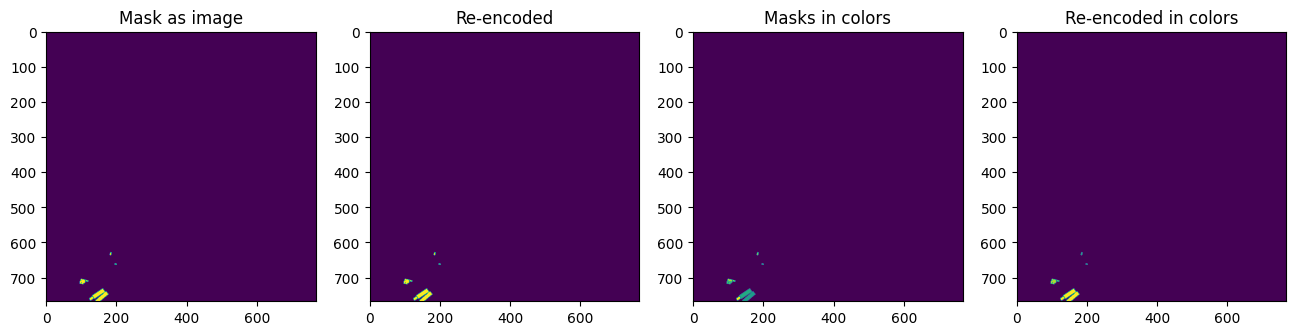

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_c = masks_as_color(rle_0)
ax3.imshow(img_c)
ax3.set_title('Masks in colors')
img_c = masks_as_color(rle_1)
ax4.imshow(img_c)
ax4.set_title('Re-encoded in colors')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

# Split into training and validation groups
We stratify by the number of boats appearing so we have nice balances in each set

ImageId  ships  has_ship has_ship_vec  file_size_kb
110345  92b5a02aa.jpg      7       1.0        [1.0]     98.583008
172891  e5f9aab93.jpg      0       0.0        [0.0]    100.449219
110447  92ddf603f.jpg      2       1.0        [1.0]    340.964844
131786  af34fa515.jpg      1       1.0        [1.0]    108.611328
81498   6c3ea6edf.jpg      1       1.0        [1.0]    118.024414
13421   11c8867b8.jpg      0       0.0        [0.0]    161.914062
26496   234e6923a.jpg      0       0.0        [0.0]    131.371094

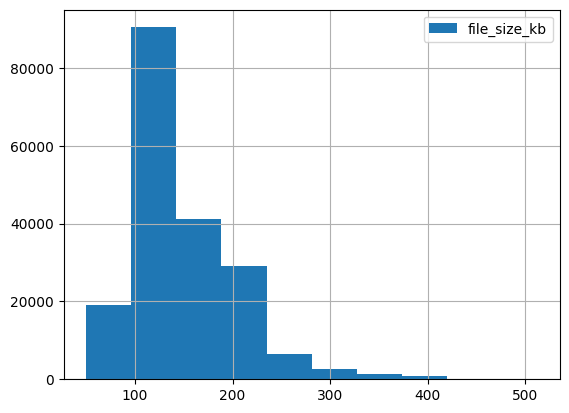

In [8]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist(legend=True)
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

### Examine Number of Ship Images
Here we examine how often ships appear and replace the ones without any ships with 0

<AxesSubplot: >

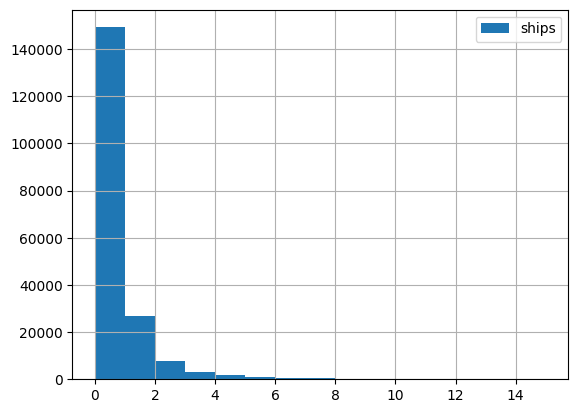

In [9]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max(), legend=True)

# Undersample Empty Images
Here we undersample the empty images to get a better balanced group with more ships to try and segment

12788 masks


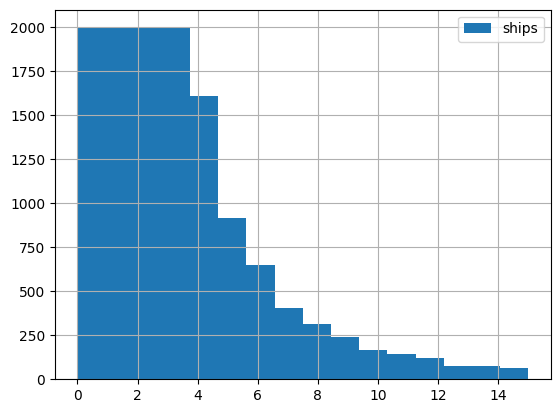

In [10]:
SAMPLES_PER_GROUP = 2000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1, legend=True)
print(balanced_train_df.shape[0], 'masks')

In [13]:
balanced_train_df

ImageId  ships  has_ship has_ship_vec  file_size_kb
ships                                                                  
0     157543  d1a50d39f.jpg      0       0.0        [0.0]    160.610352
      9447    0c8b3df76.jpg      0       0.0        [0.0]    114.267578
      188196  fa4d92655.jpg      0       0.0        [0.0]     99.411133
      25021   215aa9f62.jpg      0       0.0        [0.0]    115.090820
      122126  a268cdde3.jpg      0       0.0        [0.0]    159.090820
...                     ...    ...       ...          ...           ...
15    176401  ea9f82665.jpg     15       1.0        [1.0]    128.476562
      179547  eec04e7a8.jpg     15       1.0        [1.0]    146.968750
      186407  f7e6819bb.jpg     15       1.0        [1.0]    113.709961
      190392  fd1de824c.jpg     15       1.0        [1.0]    147.061523
      192184  ff7ac7f3c.jpg     15       1.0        [1.0]    198.810547

[12788 rows x 5 columns]

In [15]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

35364 training masks
8838 validation masks


# Decode all the RLEs into Images
We make a generator to produce batches of images

In [16]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            c_mask = c_mask.astype(np.float32)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [17]:
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0.0 1.0


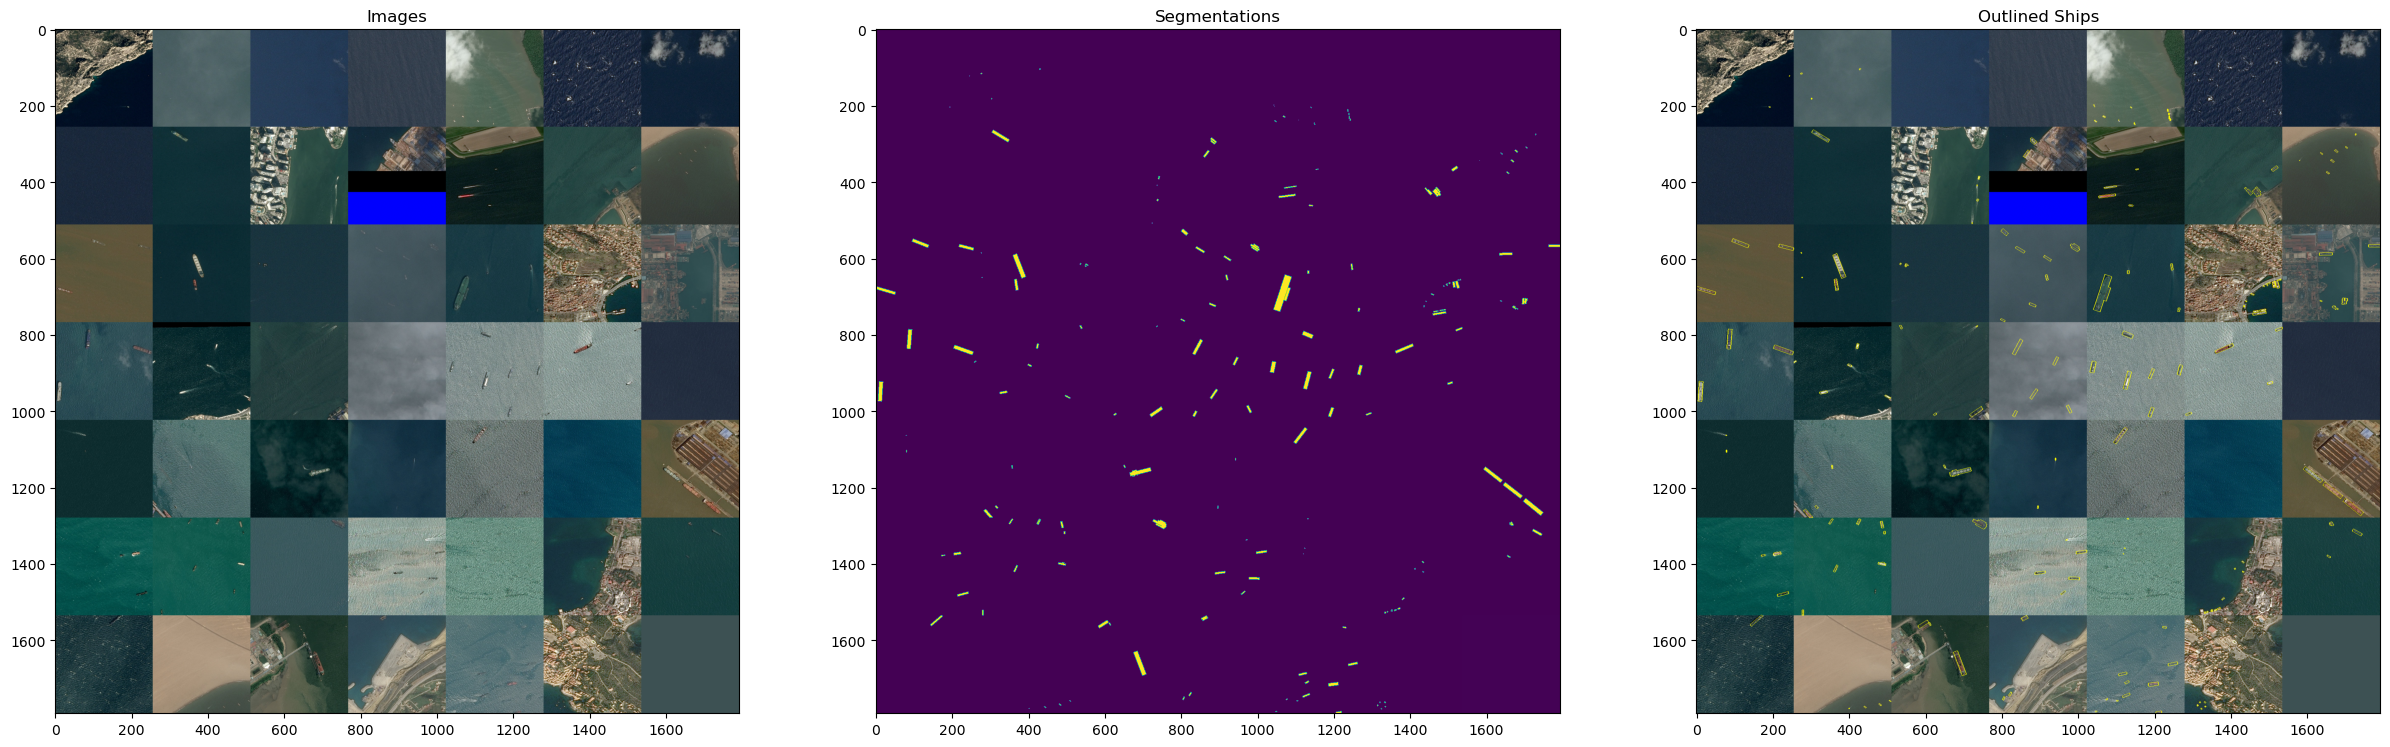

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

# Make the Validation Set

In [19]:
%%time
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(900, 256, 256, 3) (900, 256, 256, 1)
CPU times: user 9.19 s, sys: 1.57 s, total: 10.8 s
Wall time: 11.3 s


# Augment Data

In [20]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

x (48, 256, 256, 3) float32 0.0 1.0
y (48, 256, 256, 1) float32 0.0 1.0


Text(0.5, 1.0, 'ships')

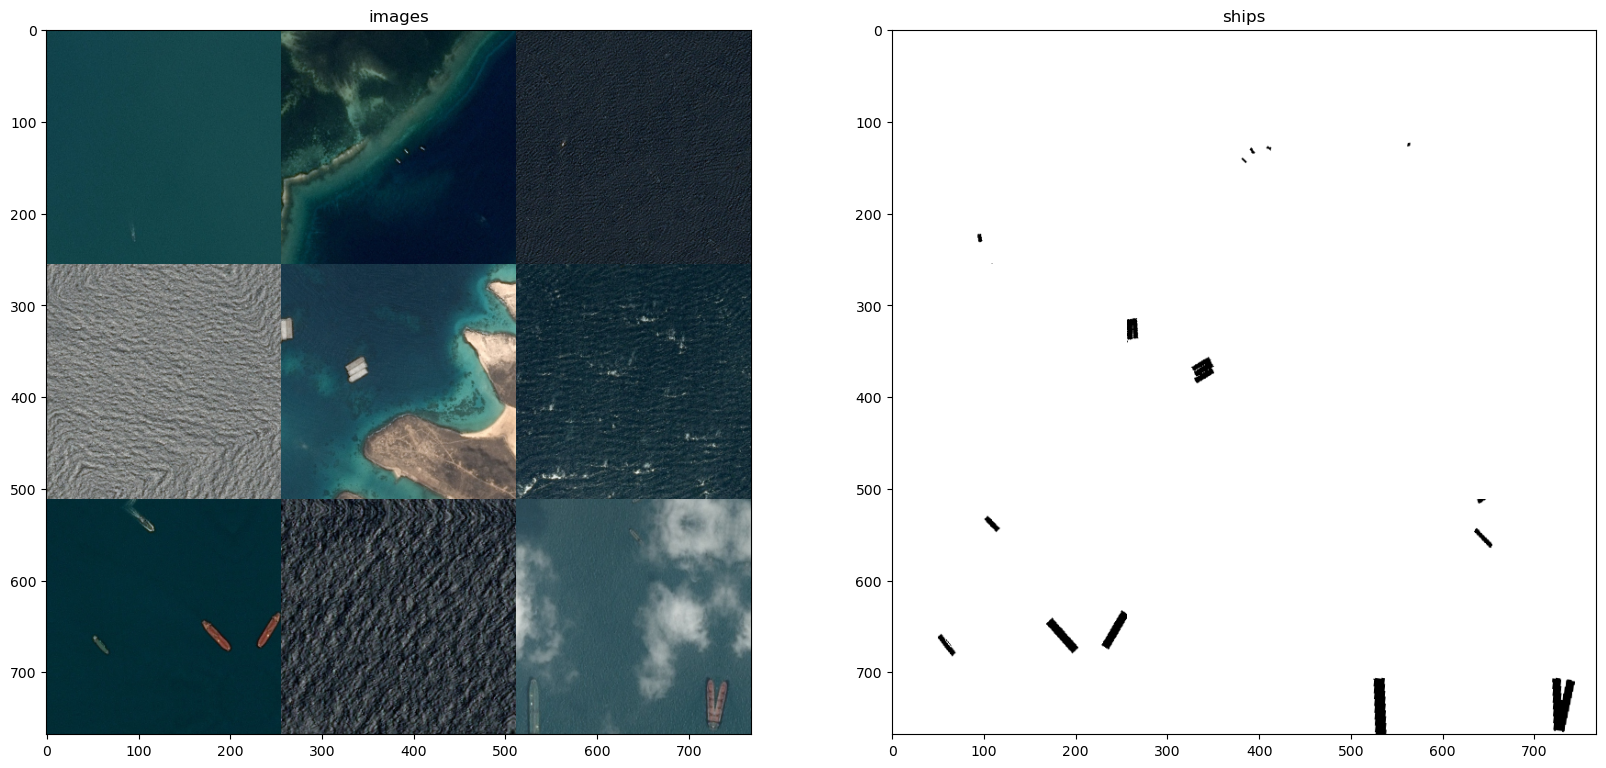

In [21]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [22]:
gc.collect()

65

# Build a Model
Here we use a slight deviation on the U-Net standard

In [23]:
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img

if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
# d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
# d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

2024-02-25 19:03:43.592041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 19:03:43.593490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 19:03:43.593636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 19:03:43.593702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_Input (InputLayer)         [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 average_pooling2d (AveragePool  (None, 256, 256, 3)  0          ['RGB_Input[0][0]']              
 ing2D)                                                                                           
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 256, 256, 3)  0          ['average_pooling2d[0][0]']      
                                                                                              

                                                                                                  
 conv2d_18 (Conv2D)             (None, 256, 256, 1)  9           ['conv2d_17[0][0]']              
                                                                                                  
 up_sampling2d_4 (UpSampling2D)  (None, 256, 256, 1)  0          ['conv2d_18[0][0]']              
                                                                                                  
Total params: 491,149
Trainable params: 491,143
Non-trainable params: 6
__________________________________________________________________________________________________


In [24]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

## intersection over union
def IoU(y_true, y_pred, eps=1e-6):
#     if np.max(y_true) == 0.0:
#         return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

In [25]:
def dice_loss(y_true, y_pred, smooth=1e-6):
#     if K.max(y_true) == 0.0:
#         return dice_loss(1-y_true, 1-y_pred) ## empty image
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return 1-dice

In [26]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8)

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2,
                      patience=20)

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [27]:
def fit():
    seg_model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=dice_loss, metrics=['binary_accuracy'])
    
    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = create_aug_gen(make_image_gen(train_df))
    loss_history = [seg_model.fit(aug_gen,
                                 steps_per_epoch=step_count,
                                 epochs=MAX_TRAIN_EPOCHS,
                                 validation_data=(valid_x, valid_y),
                                 callbacks=callbacks_list,
                                workers=1 # the generator is not very thread safe
                                           )]
    return loss_history

# while True:
#     loss_history = fit()
#     if np.min([mh.history['val_loss'] for mh in loss_history]) < -0.2:
#         break

loss_history = fit()

Epoch 1/99


2024-02-25 19:03:59.323341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-02-25 19:04:01.112536: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


9/9 [==============================] - ETA: 0s - loss: 0.9879 - binary_accuracy: 0.0174
Epoch 1: val_loss improved from inf to 0.98815, saving model to seg_model_weights.best.hdf5
9/9 [==============================] - 19s 1s/step - loss: 0.9879 - binary_accuracy: 0.0174 - val_loss: 0.9882 - val_binary_accuracy: 0.0057 - lr: 0.0010
Epoch 2/99
9/9 [==============================] - ETA: 0s - loss: 0.9864 - binary_accuracy: 0.1425
Epoch 2: val_loss improved from 0.98815 to 0.98782, saving model to seg_model_weights.best.hdf5
9/9 [==============================] - 10s 1s/step - loss: 0.9864 - binary_accuracy: 0.1425 - val_loss: 0.9878 - val_binary_accuracy: 0.0097 - lr: 0.0010
Epoch 3/99
9/9 [==============================] - ETA: 0s - loss: 0.9851 - binary_accuracy: 0.5239
Epoch 3: val_loss did not improve from 0.98782

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00033000001567415896.
9/9 [==============================] - 10s 1s/step - loss: 0.9851 - binary_accuracy: 0.5239 -

Epoch 24/99
9/9 [==============================] - ETA: 0s - loss: 0.7806 - binary_accuracy: 0.9762
Epoch 24: val_loss improved from 0.78408 to 0.78272, saving model to seg_model_weights.best.hdf5
9/9 [==============================] - 10s 1s/step - loss: 0.7806 - binary_accuracy: 0.9762 - val_loss: 0.7827 - val_binary_accuracy: 0.9763 - lr: 1.1859e-05
Epoch 25/99
9/9 [==============================] - ETA: 0s - loss: 0.7890 - binary_accuracy: 0.9781
Epoch 25: val_loss improved from 0.78272 to 0.78258, saving model to seg_model_weights.best.hdf5
9/9 [==============================] - 9s 1s/step - loss: 0.7890 - binary_accuracy: 0.9781 - val_loss: 0.7826 - val_binary_accuracy: 0.9753 - lr: 1.1859e-05
Epoch 26/99
9/9 [==============================] - ETA: 0s - loss: 0.7349 - binary_accuracy: 0.9780
Epoch 26: val_loss improved from 0.78258 to 0.78055, saving model to seg_model_weights.best.hdf5
9/9 [==============================] - 10s 1s/step - loss: 0.7349 - binary_accuracy: 0.9780 - 

Epoch 47/99
9/9 [==============================] - ETA: 0s - loss: 0.7745 - binary_accuracy: 0.9770
Epoch 47: val_loss improved from 0.76056 to 0.76036, saving model to seg_model_weights.best.hdf5
9/9 [==============================] - 9s 1s/step - loss: 0.7745 - binary_accuracy: 0.9770 - val_loss: 0.7604 - val_binary_accuracy: 0.9738 - lr: 4.2618e-07
Epoch 48/99
9/9 [==============================] - ETA: 0s - loss: 0.7940 - binary_accuracy: 0.9755
Epoch 48: val_loss improved from 0.76036 to 0.76009, saving model to seg_model_weights.best.hdf5
9/9 [==============================] - 9s 1s/step - loss: 0.7940 - binary_accuracy: 0.9755 - val_loss: 0.7601 - val_binary_accuracy: 0.9736 - lr: 4.2618e-07
Epoch 49/99
9/9 [==============================] - ETA: 0s - loss: 0.7336 - binary_accuracy: 0.9774
Epoch 49: val_loss improved from 0.76009 to 0.75984, saving model to seg_model_weights.best.hdf5
9/9 [==============================] - 9s 1s/step - loss: 0.7336 - binary_accuracy: 0.9774 - va

9/9 [==============================] - ETA: 0s - loss: 0.7534 - binary_accuracy: 0.9766
Epoch 95: val_loss did not improve from 0.75657
9/9 [==============================] - 9s 1s/step - loss: 0.7534 - binary_accuracy: 0.9766 - val_loss: 0.7566 - val_binary_accuracy: 0.9738 - lr: 1.0000e-08
Epoch 96/99
9/9 [==============================] - ETA: 0s - loss: 0.7406 - binary_accuracy: 0.9794
Epoch 96: val_loss did not improve from 0.75657
9/9 [==============================] - 9s 1s/step - loss: 0.7406 - binary_accuracy: 0.9794 - val_loss: 0.7568 - val_binary_accuracy: 0.9738 - lr: 1.0000e-08
Epoch 97/99
9/9 [==============================] - ETA: 0s - loss: 0.8002 - binary_accuracy: 0.9751
Epoch 97: val_loss did not improve from 0.75657
9/9 [==============================] - 10s 1s/step - loss: 0.8002 - binary_accuracy: 0.9751 - val_loss: 0.7567 - val_binary_accuracy: 0.9738 - lr: 1.0000e-08
Epoch 98/99
9/9 [==============================] - ETA: 0s - loss: 0.7462 - binary_accuracy: 0.9

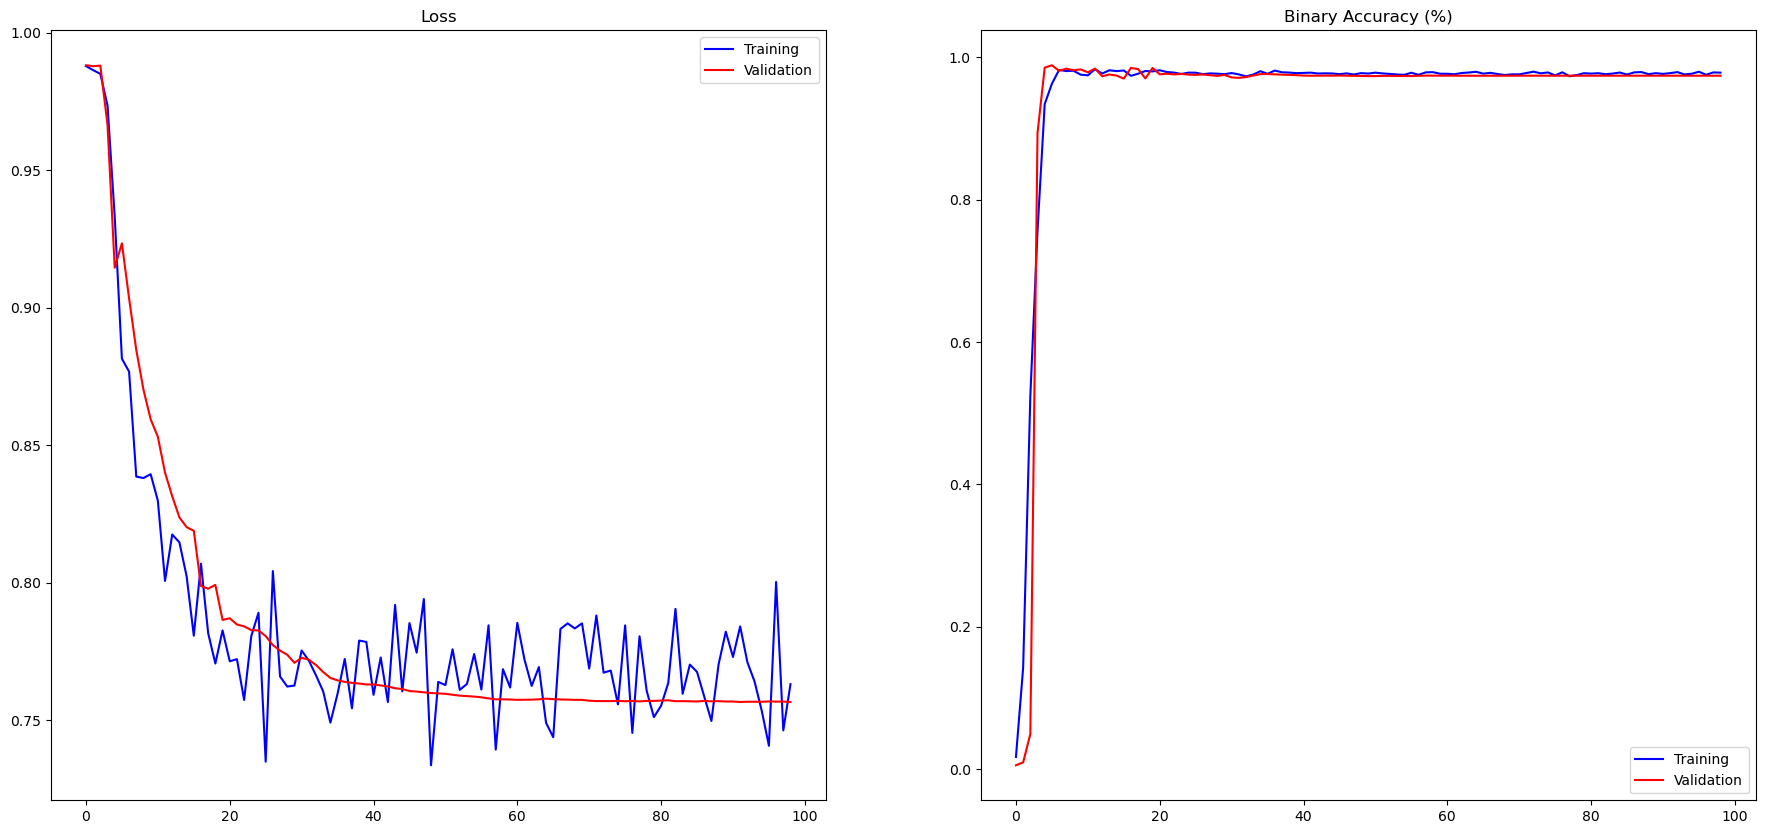

In [28]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')

show_loss(loss_history)

In [29]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')

In [30]:
pred_y = seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

29/29 [==============================] - 1s 33ms/step
(900, 256, 256, 1) 0.5201725 0.0012859495 0.02769197


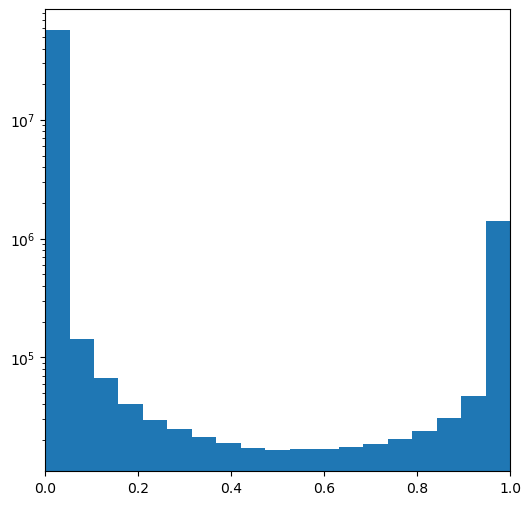

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log')

# Prepare Full Resolution Model
Here we account for the scaling so everything can happen in the model itself

In [33]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save('fullres_model.h5')

# Visualize predictions

1/1 [==============================] - 0s 20ms/step


/tmp/ipykernel_8619/133765364.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))


1/1 [==============================] - 0s 20ms/step


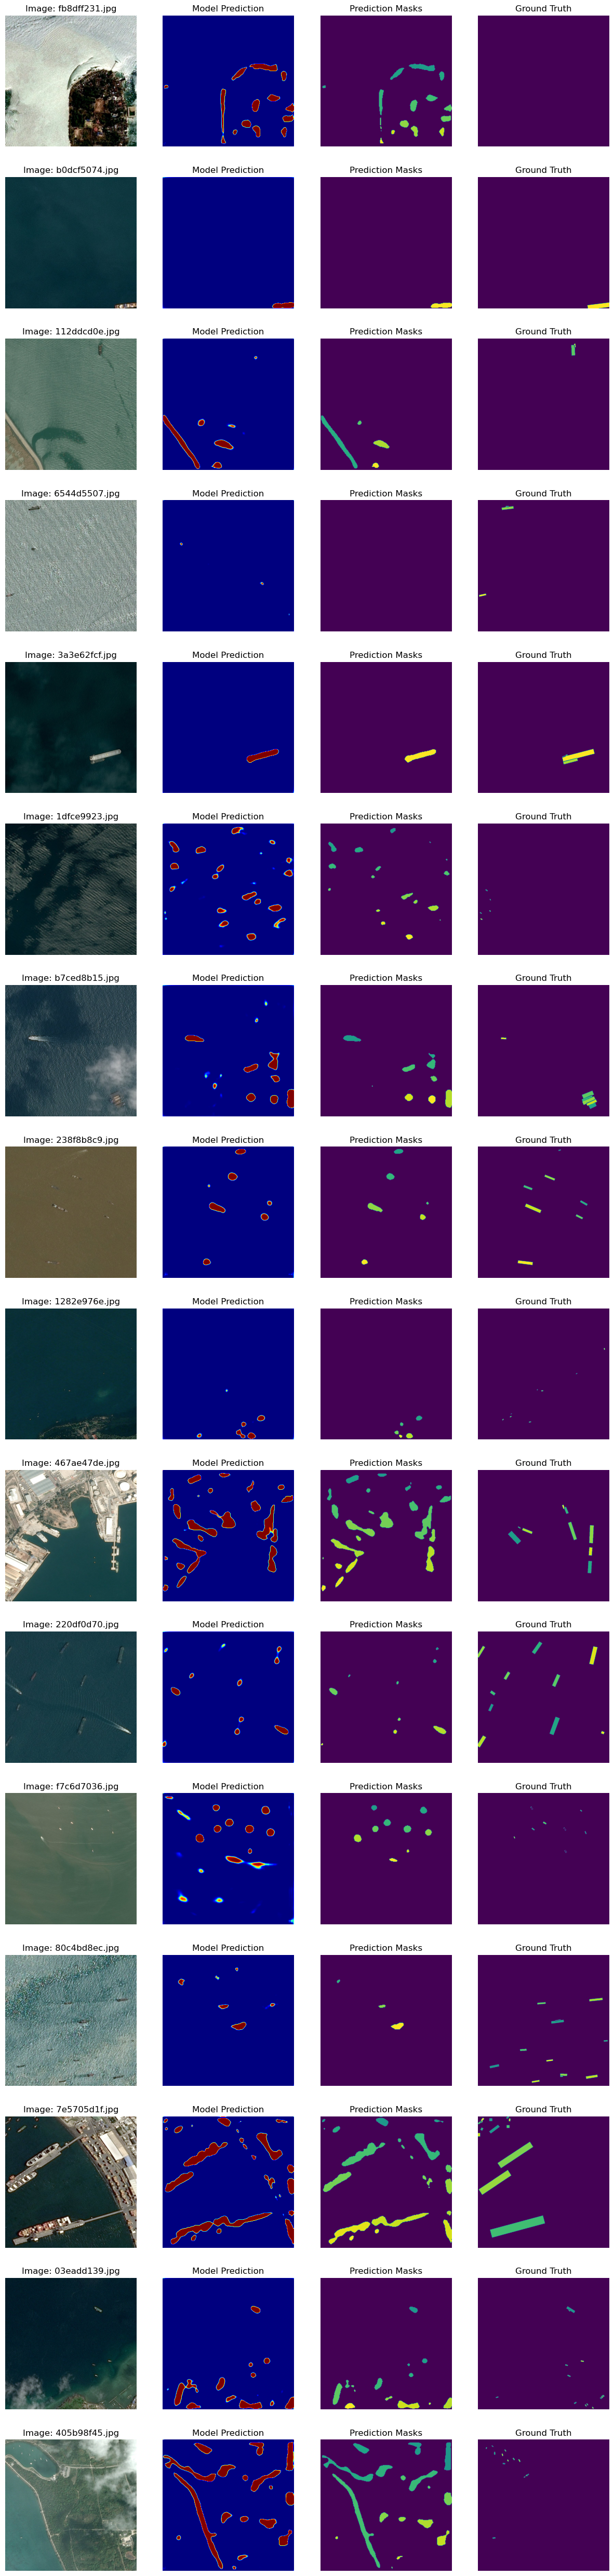

In [34]:
def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('validation.png')

# Cheking on test dataset

In [35]:
test_paths = np.array(os.listdir(test_image_dir))
print(len(test_paths), 'test images found')

15606 test images found


In [37]:
from tqdm import tqdm_notebook

def pred_encode(img, **kwargs):
    cur_seg, _ = predict(img)
    cur_rles = multi_rle_encode(cur_seg, **kwargs)
    return [[img, rle] for rle in cur_rles if rle is not None]

out_pred_rows = []
for c_img_name in tqdm_notebook(test_paths[:30]): ## only a subset
    out_pred_rows += pred_encode(c_img_name, min_max_threshold=1.0)

/tmp/ipykernel_8619/1256121194.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for c_img_name in tqdm_notebook(test_paths[:30]): ## only a subset as it takes too long to run


  0%|          | 0/30 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


In [38]:
sub = pd.DataFrame(out_pred_rows)
sub.columns = ['ImageId', 'EncodedPixels']
sub = sub[sub.EncodedPixels.notnull()]
sub.head()

ImageId                                      EncodedPixels
0  fd219c3ca.jpg  133633 1 134401 2 135169 3 135937 3 136705 3 1...
1  fd219c3ca.jpg  18459 8 19226 10 19993 12 20757 20 21524 22 22...
2  fd219c3ca.jpg  431277 2 432044 4 432811 6 433578 8 434345 10 ...
3  6c341bbd6.jpg  354846 8 355613 10 356380 12 357147 14 357914 ...
4  6c341bbd6.jpg  281187 5 281954 7 282721 9 283488 11 284255 13...

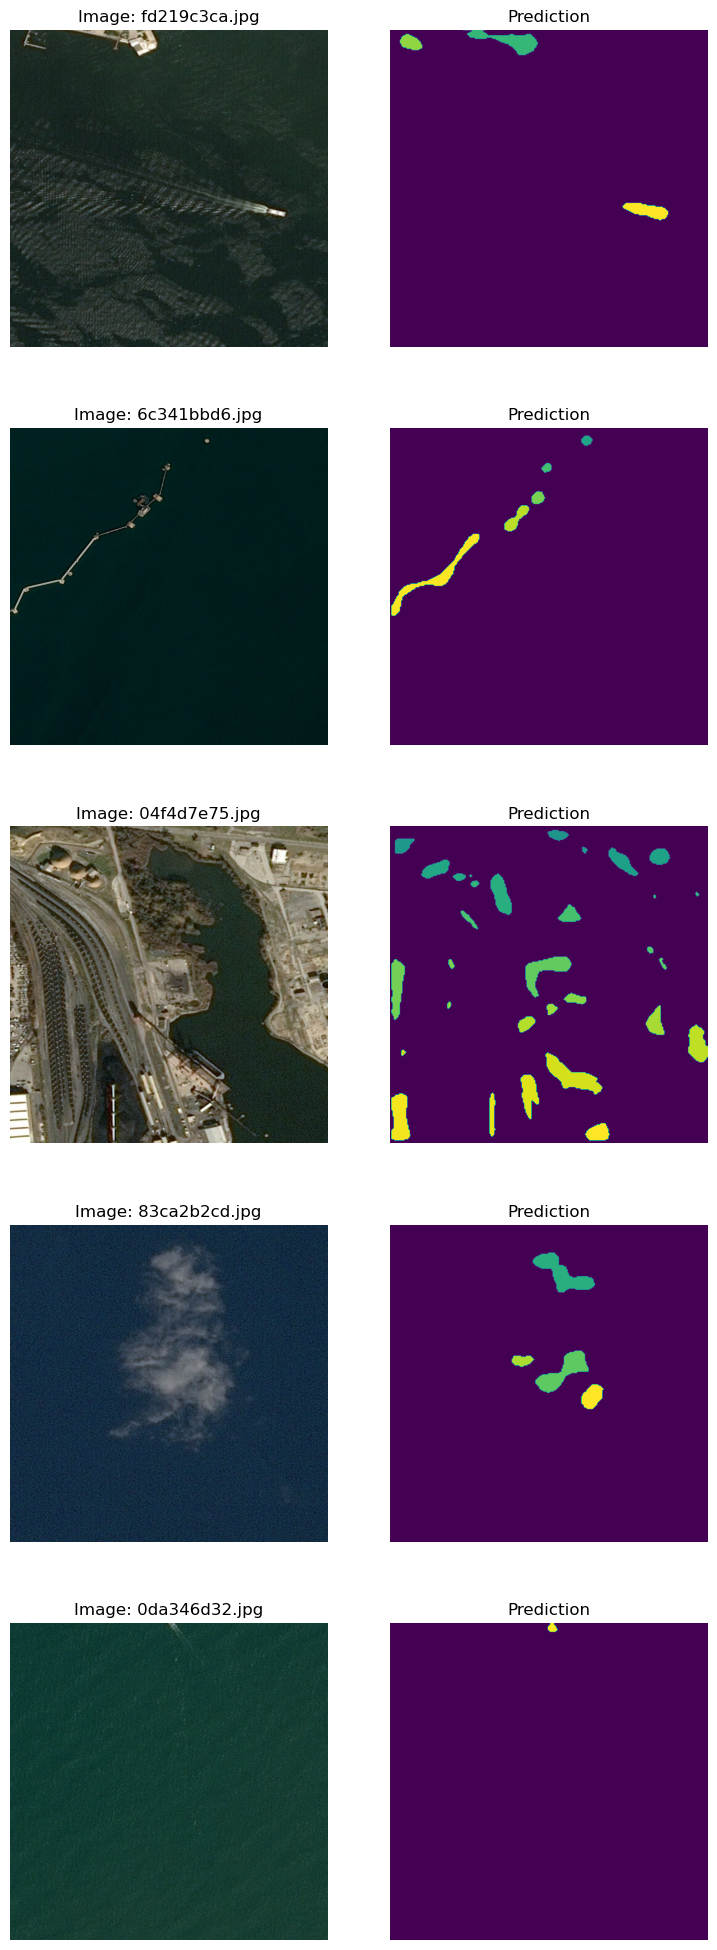

In [39]:
## let's see what we got
TOP_PREDICTIONS=5
fig, m_axs = plt.subplots(TOP_PREDICTIONS, 2, figsize = (9, TOP_PREDICTIONS*5))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2), c_img_name in zip(m_axs, sub.ImageId.unique()[:TOP_PREDICTIONS]):
    c_img = imread(os.path.join(test_image_dir, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    ax1.imshow(c_img[0])
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(masks_as_color(sub.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels']))
    ax2.set_title('Prediction')